In [1]:
import sklearn
import cv2
import os
import pickle
import math
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
!pip install mne
import mne
import pandas as pd
!pip install neupy
import neupy
from sklearn.cluster import KMeans
from neupy import algorithms
import seaborn as sns
from scipy.signal import find_peaks
from mne.utils import logger, verbose

     |████████████████████████████████| 7.0MB 2.9MB/s 
     |████████████████████████████████| 235kB 3.7MB/s 
     |████████████████████████████████| 92.7MB 45kB/s 
     |████████████████████████████████| 3.2MB 45.3MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 368kB 39.0MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.13.2 which is incompatible.
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/MyDrive/s01.dat', 'rb') as file: x = pickle.load(file, encoding='latin1')
data_ = x['data']
eeg_data=data_[:,0:32,:]
print(eeg_data.shape)

(40, 32, 8064)


**GFP Calculation**

[3.1462183  4.30571133 3.87961619 ... 3.18765695 4.04046104 4.35953958]


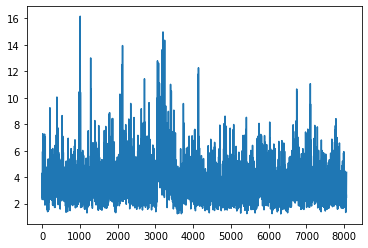

In [4]:
gfp=[]
for video in range(40):
  RMSE_array=[]
  for i in range(len(eeg_data[0][0])):
    v_mean=0
    for j in range(len(eeg_data[0])):
      v_mean=v_mean+eeg_data[video,j,i]
    v_mean=v_mean/len(eeg_data[0])
    squared_error=0
    for j in range(len(eeg_data[0])):
      squared_error=squared_error+(eeg_data[video,j,i]-v_mean)**2
    RMSE=math.sqrt(squared_error/len(eeg_data[0]))
    RMSE_array.append(RMSE)
  #print(len(RMSE_array))
  gfp.append(RMSE_array)
gfp=np.array(gfp)
#print(gfp.shape)
gfp=gfp[0]
gfp=np.transpose(gfp)
print(gfp)
plt.plot([i for i in range(8064)], gfp)

In [5]:
Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,P3,P7,PO3,O1,Oz,Pz,Fp2,AF4,Fz,F4,F8,FC6,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2 = eeg_data[0][:, 1]
col = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
m = [[0, 0, 0, Fp1, 0, Fp2, 0 , 0, 0],
    [0, 0, 0, AF3, 0, AF4, 0, 0, 0],
    [F7, 0, F3, 0, Fz, 0, F4, 0, F8],
    [0, FC5, 0, FC1, 0, FC2, 0, FC6, 0],
    [T7, 0, C3, 0, Cz, 0, C4, 0, T8],
    [0, CP5, 0, CP1, 0, CP2, 0, CP6, 0],
    [P7, 0, P3, 0, Pz, 0, P4, 0, P8],
    [0, 0, 0, PO3, 0, PO4, 0, 0, 0],
    [0, 0, 0, O1, Oz, O2, 0, 0, 0]]

info = np.array([[i, j] for i in range(9) for j in range(9) if m[i][j] != 0])

In [6]:
eeg_data=data_[0,0:32,:]

In [7]:
def _mod_kmeans(data, n_states=4, n_inits=10, max_iter=1000, thresh=1e-6,
                random_state=None, verbose=None):
    """The modified K-means clustering algorithm.
    See :func:`segment` for the meaning of the parameters and return
    values.
    """
    if not isinstance(random_state, np.random.RandomState):
        random_state = np.random.RandomState(random_state)
    n_channels, n_samples = data.shape
    print("mod kmeans",data.shape)
    # Cache this value for later
    data_sum_sq = np.sum(data ** 2)

    # Select random timepoints for our initial topographic maps
    init_times = random_state.choice(n_samples, size=n_states, replace=False)
    maps = data[:, init_times].T
    maps /= np.linalg.norm(maps, axis=1, keepdims=True)  # Normalize the maps

    prev_residual = np.inf
    for iteration in range(max_iter):
        # Assign each sample to the best matching microstate
        activation = maps.dot(data)
        segmentation = np.argmax(np.abs(activation), axis=0)

        # Recompute the topographic maps of the microstates, based on the
        # samples that were assigned to each state.
        for state in range(n_states):
            idx = (segmentation == state)
            if np.sum(idx) == 0:
                warnings.warn('Some microstates are never activated')
                maps[state] = 0
                continue
           
            # Find largest eigenvector
            # cov = data[:, idx].dot(data[:, idx].T)
            # _, vec = eigh(cov, eigvals=(n_channels - 1, n_channels - 1))
            # maps[state] = vec.ravel()
            maps[state] = data[:, idx].dot(activation[state, idx])
            maps[state] /= np.linalg.norm(maps[state])

        # Estimate residual noise
        act_sum_sq = np.sum(np.sum(maps[segmentation].T * data, axis=0) ** 2)
        residual = abs(data_sum_sq - act_sum_sq)
        residual /= float(n_samples * (n_channels - 1))

        # Have we converged?
        if (prev_residual - residual) < (thresh * residual):
            logger.info('Converged at %d iterations.' % iteration)
            break

        prev_residual = residual
    else:
        warnings.warn('Modified K-means algorithm failed to converge.')

    return maps

In [8]:
def _corr_vectors(A, B, axis=0):
    """Compute pairwise correlation of multiple pairs of vectors.
    Fast way to compute correlation of multiple pairs of vectors without
    computing all pairs as would with corr(A,B). Borrowed from Oli at Stack
    overflow. Note the resulting coefficients vary slightly from the ones
    obtained from corr due differences in the order of the calculations.
    (Differences are of a magnitude of 1e-9 to 1e-17 depending of the tested
    data).
    Parameters
    ----------
    A : ndarray, shape (n, m)
        The first collection of vectors
    B : ndarray, shape (n, m)
        The second collection of vectors
    axis : int
        The axis that contains the elements of each vector. Defaults to 0.
    Returns
    -------
    corr : ndarray, shape (m,)
        For each pair of vectors, the correlation between them.
    """
    An = A - np.mean(A, axis=axis)
    Bn = B - np.mean(B, axis=axis)
    An /= np.linalg.norm(An, axis=axis)
    Bn /= np.linalg.norm(Bn, axis=axis)
    return np.sum(An * Bn, axis=axis)

In [9]:
def plot_segmentation(segmentation, data, times, polarity=None):
    """Plot a microstate segmentation.
    Parameters
    ----------
    segmentation : list of int
        For each sample in time, the index of the state to which the sample has
        been assigned.
    times : list of float
        The time-stamp for each sample.
    polarity : list of int | None
        For each sample in time, the polarity (+1 or -1) of the activation.
    """
    gfp = np.std(data, axis=0)
    if polarity is not None:
        gfp *= polarity

    n_states = len(np.unique(segmentation))
    plt.figure(figsize=(6 * np.ptp(times), 2))
    cmap = plt.cm.get_cmap('plasma', n_states)
    plt.plot(times, gfp, color='black', linewidth=1)
    for state, color in zip(range(n_states), cmap.colors):
        plt.fill_between(times, gfp, color=color,
                         where=(segmentation == state))
    norm = mpl.colors.Normalize(vmin=0, vmax=n_states)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
    plt.xlabel('Time (s)')
    plt.title('Segmentation into %d microstates' % n_states)
    plt.autoscale(tight=True)
    plt.tight_layout()

In [10]:
def plot_maps(maps, info):
    """Plot prototypical microstate maps.
    Parameters
    ----------
    maps : ndarray, shape (n_channels, n_maps)
        The prototypical microstate maps.
    info : instance of mne.io.Info
        The info structure of the dataset, containing the location of the
        sensors.
    """
    for i, map in enumerate(maps):
        plt.figure(figsize=(10,10))
        plt.subplot(1, len(maps), i + 1)
        mne.viz.plot_topomap(map, info)

In [11]:
def segment(data, n_states=4, n_inits=10, max_iter=1000, thresh=1e-6,
            normalize=False, min_peak_dist=2, max_n_peaks=10000,
            return_polarity=False, random_state=None, verbose=None):
    
    logger.info('Finding %d microstates, using %d random intitializations' %
                (n_states, n_inits))
    #print("data: ", data.shape)
    if normalize:
        data = zscore(data, axis=1)

    # Find peaks in the global field power (GFP)
    #gfp = np.std(data, axis=0)
    print("GFP shape",gfp.shape)
    peaks, _ = find_peaks(gfp, distance=min_peak_dist)
    n_peaks = len(peaks)
    print("N-peaks: ",n_peaks)

    # Limit the number of peaks by randomly selecting them
    if max_n_peaks is not None:
        max_n_peaks = min(n_peaks, max_n_peaks)
        if not isinstance(random_state, np.random.RandomState):
            random_state = np.random.RandomState(random_state)
        chosen_peaks = random_state.choice(n_peaks, size=max_n_peaks,
                                           replace=False)
        peaks = peaks[chosen_peaks]

    # Cache this value for later
    gfp_sum_sq = np.sum(gfp ** 2)

    # Do several runs of the k-means algorithm, keep track of the best
    # segmentation.
    best_gev = 0
    best_maps = None
    best_segmentation = None
    best_polarity = None
    for _ in range(n_inits):
        maps = _mod_kmeans(data[:, peaks], n_states, n_inits, max_iter, thresh,
                           random_state, verbose)
        #print(maps)
        activation = maps.dot(data)
        segmentation = np.argmax(np.abs(activation), axis=0)
        map_corr = _corr_vectors(data, maps[segmentation].T)
        # assigned_activations = np.choose(segmentations, activation)

        # Compare across iterations using global explained variance (GEV) of
        # the found microstates.
        gev = sum((gfp * map_corr) ** 2) / gfp_sum_sq
        logger.info('GEV of found microstates: %f' % gev)
        if gev > best_gev:
            best_gev, best_maps, best_segmentation = gev, maps, segmentation
            best_polarity = np.sign(np.choose(segmentation, activation))

    if return_polarity:
        return best_maps, best_segmentation, best_polarity, best_gev
    else:
        return best_maps, best_segmentation, best_gev


Finding 3 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 18 iterations.
GEV of found microstates: 0.598978
mod kmeans (32, 1943)
Converged at 18 iterations.
GEV of found microstates: 0.599779
mod kmeans (32, 1943)
Converged at 18 iterations.
GEV of found microstates: 0.598857
mod kmeans (32, 1943)
Converged at 13 iterations.
GEV of found microstates: 0.600181
mod kmeans (32, 1943)
Converged at 12 iterations.
GEV of found microstates: 0.599186
mod kmeans (32, 1943)
Converged at 19 iterations.
GEV of found microstates: 0.599186
mod kmeans (32, 1943)
Converged at 17 iterations.
GEV of found microstates: 0.598857
mod kmeans (32, 1943)
Converged at 28 iterations.
GEV of found microstates: 0.599779
mod kmeans (32, 1943)
Converged at 18 iterations.
GEV of found microstates: 0.599779
mod kmeans (32, 1943)
Converged at 11 iterations.
GEV of found microstates: 0.599779
[[-0.14416451 -0.13210744 -0.09760691 -0.02106529  0.01109838

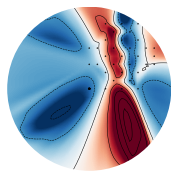

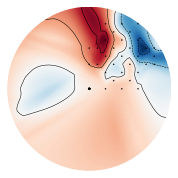

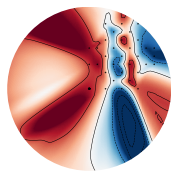

For n_outputs 3 GEV is 0.6001809929459193


Finding 4 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 34 iterations.
GEV of found microstates: 0.623824
mod kmeans (32, 1943)
Converged at 34 iterations.
GEV of found microstates: 0.625178
mod kmeans (32, 1943)
Converged at 21 iterations.
GEV of found microstates: 0.624768
mod kmeans (32, 1943)
Converged at 18 iterations.
GEV of found microstates: 0.620520
mod kmeans (32, 1943)
Converged at 17 iterations.
GEV of found microstates: 0.625153
mod kmeans (32, 1943)
Converged at 28 iterations.
GEV of found microstates: 0.620564
mod kmeans (32, 1943)
Converged at 50 iterations.
GEV of found microstates: 0.625205
mod kmeans (32, 1943)
Converged at 34 iterations.
GEV of found microstates: 0.625187
mod kmeans (32, 1943)
Converged at 29 iterations.
GEV of found microstates: 0.625368
mod kmeans (32, 1943)
Converged at 39 iterations.
GEV of found microstates: 0.625368
[[ 1.50882216e-01

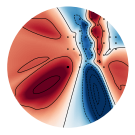

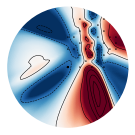

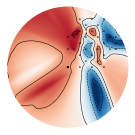

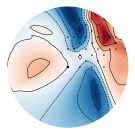

For n_outputs 4 GEV is 0.6253677530641546


Finding 5 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 44 iterations.
GEV of found microstates: 0.643600
mod kmeans (32, 1943)
Converged at 18 iterations.
GEV of found microstates: 0.643913
mod kmeans (32, 1943)
Converged at 25 iterations.
GEV of found microstates: 0.644240
mod kmeans (32, 1943)
Converged at 17 iterations.
GEV of found microstates: 0.643373
mod kmeans (32, 1943)
Converged at 21 iterations.
GEV of found microstates: 0.643265
mod kmeans (32, 1943)
Converged at 16 iterations.
GEV of found microstates: 0.644057
mod kmeans (32, 1943)
Converged at 37 iterations.
GEV of found microstates: 0.644074
mod kmeans (32, 1943)
Converged at 34 iterations.
GEV of found microstates: 0.639815
mod kmeans (32, 1943)
Converged at 59 iterations.
GEV of found microstates: 0.643918
mod kmeans (32, 1943)
Converged at 40 iterations.
GEV of found microstates: 0.644074
[[-0.13422652 -0.

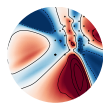

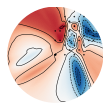

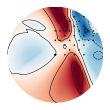

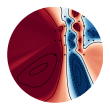

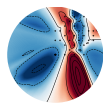

For n_outputs 5 GEV is 0.6442402955770972


Finding 6 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 31 iterations.
GEV of found microstates: 0.660177
mod kmeans (32, 1943)
Converged at 12 iterations.
GEV of found microstates: 0.662138
mod kmeans (32, 1943)
Converged at 37 iterations.
GEV of found microstates: 0.661390
mod kmeans (32, 1943)
Converged at 32 iterations.
GEV of found microstates: 0.658433
mod kmeans (32, 1943)
Converged at 41 iterations.
GEV of found microstates: 0.660802
mod kmeans (32, 1943)
Converged at 59 iterations.
GEV of found microstates: 0.661393
mod kmeans (32, 1943)
Converged at 23 iterations.
GEV of found microstates: 0.654799
mod kmeans (32, 1943)
Converged at 29 iterations.
GEV of found microstates: 0.661964
mod kmeans (32, 1943)
Converged at 33 iterations.
GEV of found microstates: 0.660657
mod kmeans (32, 1943)
Converged at 24 iterations.
GEV of found microstates: 0.655634
[[ 0.16605364  0.

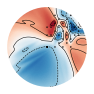

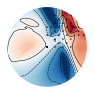

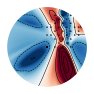

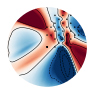

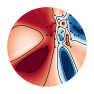

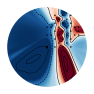

For n_outputs 6 GEV is 0.6621380561811984


Finding 7 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 45 iterations.
GEV of found microstates: 0.672198
mod kmeans (32, 1943)
Converged at 40 iterations.
GEV of found microstates: 0.672873
mod kmeans (32, 1943)
Converged at 50 iterations.
GEV of found microstates: 0.671327
mod kmeans (32, 1943)
Converged at 37 iterations.
GEV of found microstates: 0.672115
mod kmeans (32, 1943)
Converged at 26 iterations.
GEV of found microstates: 0.671326
mod kmeans (32, 1943)
Converged at 31 iterations.
GEV of found microstates: 0.673647
mod kmeans (32, 1943)
Converged at 38 iterations.
GEV of found microstates: 0.671282
mod kmeans (32, 1943)
Converged at 78 iterations.
GEV of found microstates: 0.672815
mod kmeans (32, 1943)
Converged at 54 iterations.
GEV of found microstates: 0.672437
mod kmeans (32, 1943)
Converged at 51 iterations.
GEV of found microstates: 0.671338
[[ 0.19978736  0.

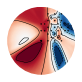

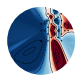

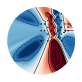

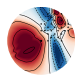

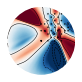

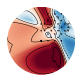

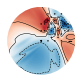

For n_outputs 7 GEV is 0.6736466891407427


Finding 8 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 43 iterations.
GEV of found microstates: 0.681795
mod kmeans (32, 1943)
Converged at 31 iterations.
GEV of found microstates: 0.681995
mod kmeans (32, 1943)
Converged at 16 iterations.
GEV of found microstates: 0.679052
mod kmeans (32, 1943)
Converged at 19 iterations.
GEV of found microstates: 0.680711
mod kmeans (32, 1943)
Converged at 28 iterations.
GEV of found microstates: 0.681495
mod kmeans (32, 1943)
Converged at 30 iterations.
GEV of found microstates: 0.680568
mod kmeans (32, 1943)
Converged at 48 iterations.
GEV of found microstates: 0.682442
mod kmeans (32, 1943)
Converged at 28 iterations.
GEV of found microstates: 0.680928
mod kmeans (32, 1943)
Converged at 18 iterations.
GEV of found microstates: 0.682780
mod kmeans (32, 1943)
Converged at 30 iterations.
GEV of found microstates: 0.681208
[[ 1.25390380e-01

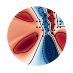

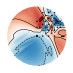

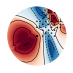

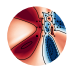

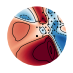

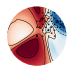

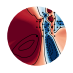

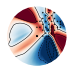

For n_outputs 8 GEV is 0.682780438633956


Finding 9 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 42 iterations.
GEV of found microstates: 0.688691
mod kmeans (32, 1943)
Converged at 43 iterations.
GEV of found microstates: 0.689345
mod kmeans (32, 1943)
Converged at 17 iterations.
GEV of found microstates: 0.688577
mod kmeans (32, 1943)
Converged at 24 iterations.
GEV of found microstates: 0.689538
mod kmeans (32, 1943)
Converged at 33 iterations.
GEV of found microstates: 0.689054
mod kmeans (32, 1943)
Converged at 37 iterations.
GEV of found microstates: 0.690462
mod kmeans (32, 1943)
Converged at 26 iterations.
GEV of found microstates: 0.687001
mod kmeans (32, 1943)
Converged at 55 iterations.
GEV of found microstates: 0.689811
mod kmeans (32, 1943)
Converged at 63 iterations.
GEV of found microstates: 0.687619
mod kmeans (32, 1943)
Converged at 21 iterations.
GEV of found microstates: 0.688084
[[ 0.23633159  0.2

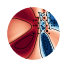

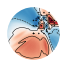

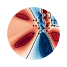

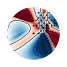

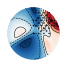

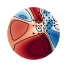

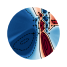

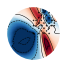

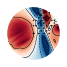

For n_outputs 9 GEV is 0.690462122474231


Finding 10 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 24 iterations.
GEV of found microstates: 0.697033
mod kmeans (32, 1943)
Converged at 33 iterations.
GEV of found microstates: 0.696005
mod kmeans (32, 1943)
Converged at 53 iterations.
GEV of found microstates: 0.696943
mod kmeans (32, 1943)
Converged at 31 iterations.
GEV of found microstates: 0.693342
mod kmeans (32, 1943)
Converged at 26 iterations.
GEV of found microstates: 0.696455
mod kmeans (32, 1943)
Converged at 20 iterations.
GEV of found microstates: 0.696099
mod kmeans (32, 1943)
Converged at 46 iterations.
GEV of found microstates: 0.695350
mod kmeans (32, 1943)
Converged at 35 iterations.
GEV of found microstates: 0.695043
mod kmeans (32, 1943)
Converged at 35 iterations.
GEV of found microstates: 0.695878
mod kmeans (32, 1943)
Converged at 32 iterations.
GEV of found microstates: 0.695209
[[-0.14284432 -0.

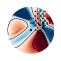

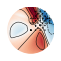

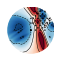

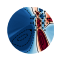

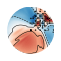

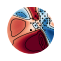

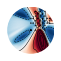

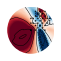

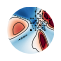

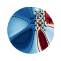

For n_outputs 10 GEV is 0.6970332651392958




In [12]:
for op in range(3,11):
  maps, segmentation, gev_kmeans = segment(eeg_data, n_states=op)
  #print(segmentation)
  print(maps)
  plot_maps(maps, info)
  print(f"For n_outputs {op} GEV is {gev_kmeans}")
  print()
  print()